## Libraries

In [457]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import plotly.express as px
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
from neo4j import GraphDatabase
from pm4py.objects.log.obj import EventLog, Trace
import pm4py
import numpy as np
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Connect to Neo4J database

In [458]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Neo4J1234"))
session = driver.session()

## Retrieve data 

In [459]:
query = f'''MATCH (n:Run) <- [:CORR] - (e:Event)
Optional match (e) - [:WASHED_IN] -> (w:WashingMachine)
Optional match (e) - [:WASHED_ON] -> (r:Rack)
Optional match (e) - [:STERILIZED_IN] -> (s:SterilizationMachine)
RETURN n.CaseID, e.KitID, n.start_timestamp, n.end_timestamp, e.Activity, e.Usuario, e.timestamp, w.machine, r.name, s.machine, s.type'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df['e.timestamp'] = pd.to_datetime(df['e.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df.head()

,n.CaseID,e.KitID,n.start_timestamp,n.end_timestamp,e.Activity,e.Usuario,e.timestamp,w.machine,r.name,s.machine,s.type
0,CONT-QUI.OFT-1-CN16354,CONT-QUI.OFT-1,2022-03-31T11:45:00.000000000+00:00,2022-03-31T11:54:00.000000000+00:00,Cargado en carro L+D,MR,2022-03-31 11:54:00+00:00,None,None,None,None
1,CONT-QUI.OFT-1-CN16354,CONT-QUI.OFT-1,2022-03-31T11:45:00.000000000+00:00,2022-03-31T11:54:00.000000000+00:00,Entrada Material Sucio,MR,2022-03-31 11:45:00+00:00,None,None,None,None
2,CONT-QUI.TRA-2-CN16353,CONT-QUI.TRA-2,2022-03-31T11:14:00.000000000+00:00,2022-03-31T13:48:00.000000000+00:00,Carga L+D iniciada,BM,2022-03-31 12:50:00+00:00,None,None,None,None
3,CONT-QUI.TRA-2-CN16353,CONT-QUI.TRA-2,2022-03-31T11:14:00.000000000+00:00,2022-03-31T13:48:00.000000000+00:00,Carga L+D liberada,MCE,2022-03-31 13:48:00+00:00,None,None,None,None
4,CONT-QUI.TRA-2-CN16353,CONT-QUI.TRA-2,2022-03-31T11:14:00.000000000+00:00,2022-03-31T13:48:00.000000000+00:00,Cargado en carro L+D,MR,2022-03-31 12:47:00+00:00,None,None,None,None


In [460]:
event_log = pm4py.format_dataframe(df, case_id='n.CaseID', activity_key='e.Activity', timestamp_key='e.timestamp')
#event_log = pm4py.convert_to_event_log(event_log)
event_log

,case:concept:name,e.KitID,n.start_timestamp,n.end_timestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,@@index
37805,CONT-CCEE.ALE-1-CN10693,CONT-CCEE.ALE-1,2022-02-22T13:21:00.000000000+00:00,2022-02-22T15:06:00.000000000+00:00,Entrada Material Sucio,LI,2022-02-22 13:21:00+00:00,None,None,None,None,37805
37808,CONT-CCEE.ALE-1-CN10693,CONT-CCEE.ALE-1,2022-02-22T13:21:00.000000000+00:00,2022-02-22T15:06:00.000000000+00:00,Cargado en carro L+D,LI,2022-02-22 13:28:00+00:00,None,None,None,None,37808
37806,CONT-CCEE.ALE-1-CN10693,CONT-CCEE.ALE-1,2022-02-22T13:21:00.000000000+00:00,2022-02-22T15:06:00.000000000+00:00,Carga L+D iniciada,MR,2022-02-22 13:57:00+00:00,None,None,None,None,37806
37807,CONT-CCEE.ALE-1-CN10693,CONT-CCEE.ALE-1,2022-02-22T13:21:00.000000000+00:00,2022-02-22T15:06:00.000000000+00:00,Carga L+D liberada,SM,2022-02-22 15:06:00+00:00,None,None,None,None,37807
34973,CONT-CCEE.ALE-1-CN11313,CONT-CCEE.ALE-1,2022-02-24T13:26:00.000000000+00:00,2022-02-24T15:03:00.000000000+00:00,Entrada Material Sucio,PG,2022-02-24 13:26:00+00:00,None,None,None,None,34973
...,...,...,...,...,...,...,...,...,...,...,...,...
44035,TRAN-QUI.TRA.ZIMMER-1-CN9347,TRAN-QUI.TRA.ZIMMER-1,2022-02-16T12:37:00.000000000+00:00,2022-02-16T21:34:00.000000000+00:00,Producción montada,MCE,2022-02-16 17:04:00+00:00,None,None,None,None,44035
44038,TRAN-QUI.TRA.ZIMMER-1-CN9347,TRAN-QUI.TRA.ZIMMER-1,2022-02-16T12:37:00.000000000+00:00,2022-02-16T21:34:00.000000000+00:00,Montaje,MCE,2022-02-16 17:04:00+00:00,None,None,None,None,44038
44032,TRAN-QUI.TRA.ZIMMER-1-CN9347,TRAN-QUI.TRA.ZIMMER-1,2022-02-16T12:37:00.000000000+00:00,2022-02-16T21:34:00.000000000+00:00,Composición de cargas,MMF,2022-02-16 17:24:00+00:00,None,None,Autoclave 1,High Temperature Sterilization,44032
44034,TRAN-QUI.TRA.ZIMMER-1-CN9347,TRAN-QUI.TRA.ZIMMER-1,2022-02-16T12:37:00.000000000+00:00,2022-02-16T21:34:00.000000000+00:00,Carga de esterilizador liberada,PN,2022-02-16 19:00:00+00:00,None,None,None,None,44034


In [461]:
original_df = event_log.copy()
original_df.fillna('NaN', inplace=True)

In [462]:
event_log = pm4py.convert_to_event_log(event_log)

## Split train test


In [463]:
prefix_traces = []
for trace in event_log:
    trace_end_flag = False
    for i,event in enumerate(trace):
        if "Comisionado" in event['concept:name']:
            trace_end_flag = True
            i+=1
            break
        if "Carga de esterilizador liberada" in event['concept:name']:
            trace_end_flag = True
    if trace_end_flag:
        prefix_traces.append(Trace(trace[:i], attributes = trace.attributes))
prefix_traces = EventLog(prefix_traces)

In [464]:
trace = pm4py.convert_to_dataframe(prefix_traces)
trace.head()


,e.KitID,n.start_timestamp,n.end_timestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,@@index,case:concept:name
0,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Entrada Material Sucio,EH,2022-01-12 09:04:00+00:00,None,None,None,None,83063,DEP-QUI.BTF-1-CN1434
1,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Carga L+D iniciada,EH,2022-01-12 09:05:00+00:00,None,None,None,None,83066,DEP-QUI.BTF-1-CN1434
2,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Cargado en carro L+D,EH,2022-01-12 09:05:00+00:00,None,None,None,None,83067,DEP-QUI.BTF-1-CN1434
3,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Montaje,MR,2022-01-12 09:12:00+00:00,None,None,None,None,83062,DEP-QUI.BTF-1-CN1434
4,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Producción montada,MR,2022-01-12 09:14:00+00:00,None,None,None,None,83068,DEP-QUI.BTF-1-CN1434


In [465]:
# get completion time and sort
completion_time_ls = list(trace.groupby(['case:concept:name'])['time:timestamp'].max())
completion_time_ls = sorted(completion_time_ls)

In [466]:
# split on 70% max time 
train_split_portion = 0.70
val_split_seperation = 0.85
total_data = len(completion_time_ls)
train_len = int(train_split_portion*total_data)
val_len = int(val_split_seperation*total_data)
last_train_completion_time = completion_time_ls[train_len]
last_val_completion_time = completion_time_ls[val_len]
val_start_time = last_train_completion_time
last_train_completion_time,last_val_completion_time

(Timestamp('2022-02-23 21:31:00+0000', tz='UTC'),
 Timestamp('2022-03-10 13:06:00+0000', tz='UTC'))

In [467]:
# take all traces where start dates are after the last_train_completion_time
dtype_list = list(trace.dtypes) # get original types of the columns
train_df = pd.DataFrame(columns = trace.columns)
test_df = pd.DataFrame(columns = trace.columns)
val_df = pd.DataFrame(columns = trace.columns)
train_count,test_count,val_count = 0,0,0
intersecting_traces = []
for name, group in trace.groupby(['case:concept:name'],as_index=False):
    if group['time:timestamp'].iloc[-1] <= last_train_completion_time:
        train_df = train_df.append(group)
        train_count+=1
    # elif (group['startTime'].iloc[0] >= last_train_completion_time) and (group['completeTime'].iloc[-1] <= last_val_completion_time):
    elif group['time:timestamp'].iloc[-1] <= last_val_completion_time:
        val_df = val_df.append(group)
        val_count+=1        
    # elif group['startTime'].iloc[0] >= last_val_completion_time:
    #     test_df = test_df.append(group)
    #     test_count+=1
    else:
        test_df = test_df.append(group)
        test_count+=1
        # intersecting_traces.append(group)


# converting train and test to their original data types
for i,col in enumerate(train_df.columns):
    train_df[col] = train_df[col].astype(dtype_list[i])

for i,col in enumerate(test_df.columns):
    test_df[col] = test_df[col].astype(dtype_list[i])

for i,col in enumerate(val_df.columns):
    val_df[col] = val_df[col].astype(dtype_list[i])


print("train, val and test count")
print(train_count,val_count,test_count)

train, val and test count
9499 2019 2022


## Data encoding

In [468]:
def get_ohe_dict(categorical_vars, df):
    ohe_dict = {}
    for var in categorical_vars:
        var_dict = {}
        print(df[var].unique())
        var_data = sorted(df[var].unique())
        var_len = len(var_data)
        for i,cat in enumerate(var_data):
            var_dict[cat] = [0]*var_len
            var_dict[cat][i] = 1

        ohe_dict[var] = var_dict

    return ohe_dict

In [469]:
# function to save the data
def save_data(X,y,feature_names, save_path):
    data_dict = {}
    data_dict['X'] = X
    data_dict['y'] = y
    data_dict['feature_names'] = feature_names

    # save pickle
    with open(save_path, 'wb') as handle:
        pickle.dump(data_dict, handle)

In [470]:
def load_data(load_path):
    with open(load_path, 'rb') as handle:
        data = pickle.load(handle)
    return data

### Train data

In [471]:
t_length = 10
save_path_base = '/Users/abdalrhman/Documents/bdma-thesis/python/data/'
df_type = 'train'
permits = train_df

In [472]:
trace_log = pm4py.format_dataframe(permits, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
trace_log = pm4py.convert_to_event_log(trace_log)

In [473]:
is_delayed = []
for trace in trace_log:
    flag = False
    for i,event in enumerate(trace):
        startTimestamp = pd.to_datetime(event['n.start_timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
        finishTimestamp = pd.to_datetime(event['n.end_timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')

        duration_minutes = (finishTimestamp - startTimestamp).total_seconds() / 60

        if duration_minutes > 370:
            flag = True
            break
    
    if flag:
        is_delayed.append(1)
    else:
        is_delayed.append(0)

In [474]:
prefix_traces = []
for trace in trace_log:
    for i,event in enumerate(trace):
        if ("Comisionado" not in event['concept:name']) or ("Carga de esterilizador liberada" not in event['concept:name']):
            break
    prefix_traces.append(Trace(trace[:i], attributes = trace.attributes))
prefix_traces = EventLog(prefix_traces)

In [475]:
trace_prefixes = EventLog([Trace(trace[0:t_length], attributes = trace.attributes) for trace in prefix_traces])

In [476]:
df = pm4py.convert_to_dataframe(trace_log)
df.head(5)

,e.KitID,n.start_timestamp,n.end_timestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,@@index,case:concept:name
0,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Entrada Material Sucio,EH,2022-01-12 09:04:00+00:00,None,None,None,None,0,DEP-QUI.BTF-1-CN1434
1,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Carga L+D iniciada,EH,2022-01-12 09:05:00+00:00,None,None,None,None,1,DEP-QUI.BTF-1-CN1434
2,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Cargado en carro L+D,EH,2022-01-12 09:05:00+00:00,None,None,None,None,2,DEP-QUI.BTF-1-CN1434
3,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Montaje,MR,2022-01-12 09:12:00+00:00,None,None,None,None,3,DEP-QUI.BTF-1-CN1434
4,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,2022-01-12T21:42:00.000000000+00:00,Producción montada,MR,2022-01-12 09:14:00+00:00,None,None,None,None,4,DEP-QUI.BTF-1-CN1434


In [477]:
cases = list(df.groupby(['case:concept:name'],sort=False)['e.KitID'].first().keys())
df_dict = dict()
df_dict['case:concept:name'] = cases
df_dict['is_delayed'] = is_delayed
temp_df = pd.DataFrame(df_dict)

# merge target variable with permits
df = df.merge(temp_df,on=['case:concept:name'])
df.drop(columns=['n.end_timestamp', 'time:timestamp'], inplace=True)
df.head()

,e.KitID,n.start_timestamp,concept:name,e.Usuario,w.machine,r.name,s.machine,s.type,@@index,case:concept:name,is_delayed
0,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,Entrada Material Sucio,EH,None,None,None,None,0,DEP-QUI.BTF-1-CN1434,1
1,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,Carga L+D iniciada,EH,None,None,None,None,1,DEP-QUI.BTF-1-CN1434,1
2,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,Cargado en carro L+D,EH,None,None,None,None,2,DEP-QUI.BTF-1-CN1434,1
3,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,Montaje,MR,None,None,None,None,3,DEP-QUI.BTF-1-CN1434,1
4,DEP-QUI.BTF-1,2022-01-12T09:04:00.000000000+00:00,Producción montada,MR,None,None,None,None,4,DEP-QUI.BTF-1-CN1434,1


In [478]:
save_path = save_path_base + df_type +'_trace_len_'+str(t_length)+ '.csv'
df.to_csv(save_path,index=False)

In [479]:
str_ev_attr = ['concept:name', 'e.Usuario', 'w.machine', 'r.name', 's.machine',	's.type']
str_tr_attr = ['e.KitID']
categorical_vars = str_ev_attr + str_tr_attr
ohe_dict = get_ohe_dict(categorical_vars, original_df)
categorical_vars

['Entrada Material Sucio' 'Cargado en carro L+D' 'Carga L+D iniciada'
 'Carga L+D liberada' 'Montaje' 'Producción montada'
 'Composición de cargas' 'Carga de esterilizador liberada' 'Comisionado']
['LI' 'MR' 'SM' 'PG' 'EH' 'CLE' 'VA' 'PN' 'CM' 'SP' 'MMF' 'ER' 'VS' 'BM'
 'MCE' 'ML' 'AV' 'MAA' 'MGP' 'DF']
['NaN' 'Lavadora 2' 'Lavadora 3' 'Lavadora 1' 'Lavadora 4' 'Jupiter'
 'Esclusa Lavado' 'Esclusa Reposicion' 'Esclusa Caducado']
['NaN' 'Rack-Lav. 03' 'Rack-Lav. 04' 'Rack-Lav. 01' 'Rack-Lav. 06'
 'Rack-Lav. 07' 'Rack-Lav. 10' 'Rack-Lav. 05' 'Rack-Lav. 02'
 'Rack-Lav. 09' 'Rack-Lav. 08' 'Rack-Jupiter 02' 'Rack-Jupiter 01'
 'Esclusa 03' 'Esclusa 02' 'Esclusa 01']
['NaN' 'Autoclave 1' 'Autoclave 2' 'Autoclave 4' 'Autoclave 3'
 'Amsco Vpro' 'Amsco Eagle']
['NaN' 'High Temperature Sterilization' 'Low Temperature Sterilization']
['CONT-CCEE.ALE-1' 'CONT-CCEE.CG-1' 'CONT-CCEE.CG-2' ...
 'TRAN-QUI.TRA.STRYKER-7' 'TRAN-QUI.TRA.STRYKER-8' 'TRAN-QUI.TRA.ZIMMER-1']


['concept:name',
 'e.Usuario',
 'w.machine',
 'r.name',
 's.machine',
 's.type',
 'e.KitID']

In [480]:
data = []

for id, group in df.groupby(['case:concept:name']):
    feature_vec = []

    # add categorical and numerical event attributes
    for cat_atr in str_ev_attr[:1]:
        attr_length = len(list(ohe_dict[cat_atr].values())[0])
        str_ev_vec = np.array([0]*attr_length)

        for ca in group[cat_atr]:
            str_ev_vec  = str_ev_vec + np.array(ohe_dict[cat_atr][ca])

        feature_vec.extend(list(str_ev_vec))

    data.append(feature_vec)

In [481]:
encode_name = 'frequency_encode_'
save_path = save_path_base + encode_name + df_type +'_trace_len_'+str(t_length)+ '.pickle'
save_data(data, is_delayed, ohe_dict ,save_path)

### Test data

In [482]:
df_type = 'test'
permits = test_df

In [483]:
test_df.head()

,e.KitID,n.start_timestamp,n.end_timestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,@@index,case:concept:name
79,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,2022-03-14T18:38:00.000000000+00:00,Entrada Material Sucio,PG,2022-03-14 12:31:00+00:00,None,None,None,None,16855,DEP-QUI.GIN-1-CN14136
80,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,2022-03-14T18:38:00.000000000+00:00,Cargado en carro L+D,SP,2022-03-14 13:01:00+00:00,None,None,None,None,16852,DEP-QUI.GIN-1-CN14136
81,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,2022-03-14T18:38:00.000000000+00:00,Carga L+D iniciada,EH,2022-03-14 14:00:00+00:00,None,None,None,None,16851,DEP-QUI.GIN-1-CN14136
82,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,2022-03-14T18:38:00.000000000+00:00,Carga L+D liberada,MMF,2022-03-14 15:13:00+00:00,Lavadora 4,Rack-Lav. 07,None,None,16854,DEP-QUI.GIN-1-CN14136
83,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,2022-03-14T18:38:00.000000000+00:00,Montaje,ER,2022-03-14 15:35:00+00:00,None,None,None,None,16853,DEP-QUI.GIN-1-CN14136


In [484]:
event_log = pm4py.format_dataframe(permits, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
event_log = pm4py.convert_to_event_log(event_log)
event_log

[{'attributes': {'concept:name': 'DEP-QUI.GIN-1-CN14136'}, 'events': [{'e.KitID': 'DEP-QUI.GIN-1', 'n.start_timestamp': neo4j.time.DateTime(2022, 3, 14, 12, 31, 0, 0, tzinfo=<UTC>), 'n.end_timestamp': neo4j.time.DateTime(2022, 3, 14, 18, 38, 0, 0, tzinfo=<UTC>), 'concept:name': 'Entrada Material Sucio', 'e.Usuario': 'PG', 'time:timestamp': Timestamp('2022-03-14 12:31:00+0000', tz='UTC'), 'w.machine': None, 'r.name': None, 's.machine': None, 's.type': None, '@@index': 79}, '..', {'e.KitID': 'DEP-QUI.GIN-1', 'n.start_timestamp': neo4j.time.DateTime(2022, 3, 14, 12, 31, 0, 0, tzinfo=<UTC>), 'n.end_timestamp': neo4j.time.DateTime(2022, 3, 14, 18, 38, 0, 0, tzinfo=<UTC>), 'concept:name': 'Composición de cargas', 'e.Usuario': 'CM', 'time:timestamp': Timestamp('2022-03-14 17:00:00+0000', tz='UTC'), 'w.machine': None, 'r.name': None, 's.machine': None, 's.type': None, '@@index': 85}]}, '....', {'attributes': {'concept:name': 'TRAN-QUI.TRA.ZIMMER-1-CN12543'}, 'events': [{'e.KitID': 'TRAN-QUI.TR

In [485]:
is_delayed = []
for trace in event_log:
    flag = False
    for i,event in enumerate(trace):
        startTimestamp = pd.to_datetime(event['n.start_timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
        finishTimestamp = pd.to_datetime(event['n.end_timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')

        duration_minutes = (finishTimestamp - startTimestamp).total_seconds() / 60

        if duration_minutes > 370:
            flag = True
            break
    
    if flag:
        is_delayed.append(1)
    else:
        is_delayed.append(0)

In [486]:
prefix_traces = []
for trace in event_log:
    for i,event in enumerate(trace):
        if ("Comisionado" not in event['concept:name']) or ("Carga de esterilizador liberada" not in event['concept:name']):
            break
    prefix_traces.append(Trace(trace[:i], attributes = trace.attributes))
prefix_traces = EventLog(prefix_traces)

In [487]:
trace_prefixes = EventLog([Trace(trace[0:t_length], attributes = trace.attributes) for trace in prefix_traces])

In [488]:
df = pm4py.convert_to_dataframe(event_log)
df.head(5)

,e.KitID,n.start_timestamp,n.end_timestamp,concept:name,e.Usuario,time:timestamp,w.machine,r.name,s.machine,s.type,@@index,case:concept:name
0,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,2022-03-14T18:38:00.000000000+00:00,Entrada Material Sucio,PG,2022-03-14 12:31:00+00:00,None,None,None,None,79,DEP-QUI.GIN-1-CN14136
1,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,2022-03-14T18:38:00.000000000+00:00,Cargado en carro L+D,SP,2022-03-14 13:01:00+00:00,None,None,None,None,80,DEP-QUI.GIN-1-CN14136
2,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,2022-03-14T18:38:00.000000000+00:00,Carga L+D iniciada,EH,2022-03-14 14:00:00+00:00,None,None,None,None,81,DEP-QUI.GIN-1-CN14136
3,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,2022-03-14T18:38:00.000000000+00:00,Carga L+D liberada,MMF,2022-03-14 15:13:00+00:00,Lavadora 4,Rack-Lav. 07,None,None,82,DEP-QUI.GIN-1-CN14136
4,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,2022-03-14T18:38:00.000000000+00:00,Montaje,ER,2022-03-14 15:35:00+00:00,None,None,None,None,83,DEP-QUI.GIN-1-CN14136


In [489]:
cases = list(df.groupby(['case:concept:name'],sort=False)['e.KitID'].first().keys())
df_dict = dict()
df_dict['case:concept:name'] = cases
df_dict['is_delayed'] = is_delayed
temp_df = pd.DataFrame(df_dict)
df.drop(columns=['n.end_timestamp', 'time:timestamp'], inplace=True)

# merge target variable with permits
df = df.merge(temp_df,on=['case:concept:name'])
df.head()

,e.KitID,n.start_timestamp,concept:name,e.Usuario,w.machine,r.name,s.machine,s.type,@@index,case:concept:name,is_delayed
0,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,Entrada Material Sucio,PG,None,None,None,None,79,DEP-QUI.GIN-1-CN14136,0
1,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,Cargado en carro L+D,SP,None,None,None,None,80,DEP-QUI.GIN-1-CN14136,0
2,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,Carga L+D iniciada,EH,None,None,None,None,81,DEP-QUI.GIN-1-CN14136,0
3,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,Carga L+D liberada,MMF,Lavadora 4,Rack-Lav. 07,None,None,82,DEP-QUI.GIN-1-CN14136,0
4,DEP-QUI.GIN-1,2022-03-14T12:31:00.000000000+00:00,Montaje,ER,None,None,None,None,83,DEP-QUI.GIN-1-CN14136,0


In [490]:
save_path = save_path_base + df_type +'_trace_len_'+str(t_length)+ '.csv'
df.to_csv(save_path,index=False)

In [491]:
encode_name = 'frequency_encode_'
save_path = save_path_base + encode_name + 'train' +'_trace_len_'+str(t_length)+ '.pickle'
loaded_data = load_data(save_path)
ohe_dict = loaded_data['feature_names']

In [492]:
data = []

for id, group in df.groupby(['case:concept:name']):
    feature_vec = []

    # add categorical and numerical event attributes
    for cat_atr in str_ev_attr[:1]:
        attr_length = len(list(ohe_dict[cat_atr].values())[0])
        str_ev_vec = np.array([0]*attr_length)

        for ca in group[cat_atr]:
            str_ev_vec  = str_ev_vec + np.array(ohe_dict[cat_atr][ca])

        feature_vec.extend(list(str_ev_vec))

    data.append(feature_vec)

In [493]:
encode_name = 'frequency_encode_'
save_path = save_path_base + encode_name + df_type +'_trace_len_'+str(t_length)+ '.pickle'
save_data(data, is_delayed, ohe_dict ,save_path)

## Modeling

In [494]:
data_test = load_data(save_path_base + "frequency_encode_test_trace_len_10.pickle")
data_train = load_data(save_path_base + "frequency_encode_train_trace_len_10.pickle")

In [495]:
X_train = np.array(data_train['X'])
X_test = np.array(data_test['X'])
y_train = np.array(data_train['y'])
y_test = np.array(data_test['y'])

In [496]:
results_df = pd.DataFrame(index=['Decision Tree (Default)'],
                          columns=['F-score', 'Precision','Recall', 'Accuracy'])

In [497]:
len(y_test)

2022

In [498]:
# Create Decision Tree classifier object
dt = DecisionTreeClassifier()

# Train Decision Tree Classifier
dt_fit = dt.fit(X_train,y_train)

#Predict the response for test dataset
dt_predict = dt_fit.predict(X_test)

results_df.loc['Decision Tree (Default)',:] = [f1_score(y_test,dt_predict, average='macro'), precision_score(y_test,dt_predict), recall_score(y_test,dt_predict),accuracy_score(y_test,dt_predict)]

results_df.sort_values(by='F-score', ascending=False)

,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.557185,0.837209,0.193809,0.689911


[Text(0.5170838891006098, 0.98, 'x[3] <= 0.5\ngini = 0.498\nsamples = 9499\nvalue = [4467, 5032]'),
 Text(0.2821431974085366, 0.94, 'x[7] <= 1.5\ngini = 0.338\nsamples = 4081\nvalue = [3203, 878]'),
 Text(0.13674256859756098, 0.9, 'x[6] <= 0.5\ngini = 0.241\nsamples = 3076\nvalue = [2645, 431]'),
 Text(0.09055830792682927, 0.86, 'x[7] <= 0.5\ngini = 0.229\nsamples = 3026\nvalue = [2626, 400]'),
 Text(0.046303353658536585, 0.82, 'x[5] <= 0.5\ngini = 0.354\nsamples = 265\nvalue = [204, 61]'),
 Text(0.020960365853658538, 0.78, 'x[0] <= 3.5\ngini = 0.182\nsamples = 208\nvalue = [187, 21]'),
 Text(0.006097560975609756, 0.74, 'x[2] <= 1.5\ngini = 0.018\nsamples = 111\nvalue = [110, 1]'),
 Text(0.003048780487804878, 0.7, 'gini = 0.0\nsamples = 70\nvalue = [70, 0]'),
 Text(0.009146341463414634, 0.7, 'x[2] <= 2.5\ngini = 0.048\nsamples = 41\nvalue = [40, 1]'),
 Text(0.006097560975609756, 0.66, 'gini = 0.091\nsamples = 21\nvalue = [20, 1]'),
 Text(0.012195121951219513, 0.66, 'gini = 0.0\nsamples

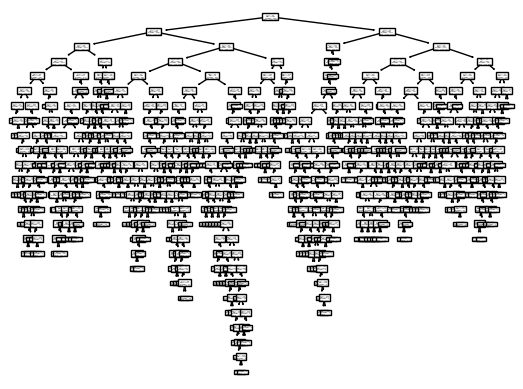

In [499]:
tree.plot_tree(dt_fit)

In [500]:
# Training the Logistic Regression model on the Training set
lr = LogisticRegression(random_state=42)
lr_fit = lr.fit(X_train, y_train)
# Predicting the Test set results
lr_predict = lr_fit.predict(X_test)

results_df.loc['Logistic Regression (Default)',:] = [f1_score(y_test,lr_predict, average='macro'), precision_score(y_test,lr_predict), recall_score(y_test,lr_predict),accuracy_score(y_test,lr_predict)]

results_df.sort_values(by='F-score', ascending=False)

,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.557185,0.837209,0.193809,0.689911
Logistic Regression (Default),0.54678,0.725888,0.192463,0.676558


In [501]:
solvers = ['lbfgs','newton-cg','liblinear','sag','saga']
penalty = ['l2', 'None']
c_values = [100, 10, 1.0, 0.1, 0.01]
max_iteration= [100, 200, 500, 1000, 2000, 5000]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values,max_iter=max_iteration)

lr_grid = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
lr_grid_fit = lr_grid.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(lr_grid.best_estimator_, X_train, y_train, scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['Logistic Regression (Grid CV Tuning)',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score', ascending=False)

/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/sklearn/lin

,F-score,Precision,Recall,Accuracy
Logistic Regression (Grid CV Tuning),0.745359,0.763978,0.749181,0.752071
Decision Tree (Default),0.557185,0.837209,0.193809,0.689911
Logistic Regression (Default),0.54678,0.725888,0.192463,0.676558


In [502]:
randomForestModel=RandomForestClassifier(n_estimators=75)
randomForestModel.fit(X_train,y_train)
y_pred=randomForestModel.predict(X_test)

In [503]:
print('Accuracy Score: ',accuracy_score(y_test,y_pred))
print('Recall Score: ',recall_score(y_test,y_pred))
print('Jaccard Score: ',jaccard_score(y_test,y_pred))
print('F1 Score: ',f1_score(y_test,y_pred))
print('Precision Score: ',precision_score(y_test,y_pred))

plot = px.imshow(np.around(confusion_matrix(y_test, y_pred, normalize='true'),3), 
                template='simple_white',
                text_auto=True, 
                aspect="True", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
plot.update_xaxes(side="bottom")
plot.show()

Accuracy Score:  0.6874381800197824
Recall Score:  0.20861372812920592
Jaccard Score:  0.19695044472681067
F1 Score:  0.3290870488322718
Precision Score:  0.7788944723618091


In [504]:
data = df.copy()
dataFrame=data.copy()
new_y=dataFrame.pop('is_delayed').values
new_x=dataFrame.values
X_train,X_test,y_train,y_test=train_test_split(new_x,new_y,train_size=0.7,random_state=1)
y_train = data['is_delayed']
y_train = np.array(y_train).astype(int)
X_train = data.drop(["is_delayed"], axis=1)
y_test = data['is_delayed']
y_test = np.array(y_test).astype(int)
X_test = data.drop(["is_delayed"], axis=1)

In [505]:
# create target variable for prediction
y = data['is_delayed']
y = np.array(y).astype(int)
x = data.drop(["is_delayed"], axis=1)

In [506]:
# test implementation of Random Forest Classifier (seed = 0) 
clf = RandomForestClassifier(random_state=0)

# Convert categorical variables to numerical using label encoding
label_encoder = LabelEncoder()
x_encoded = x.apply(label_encoder.fit_transform)

# Now fit your RandomForestClassifier
clf.fit(x_encoded, y)
# fit the model
#clf.fit(x, y)
#RandomForestClassifier(random_state=0)

# predict
clf.predict(x_encoded)

array([0, 0, 0, ..., 1, 1, 1])

<AxesSubplot:>

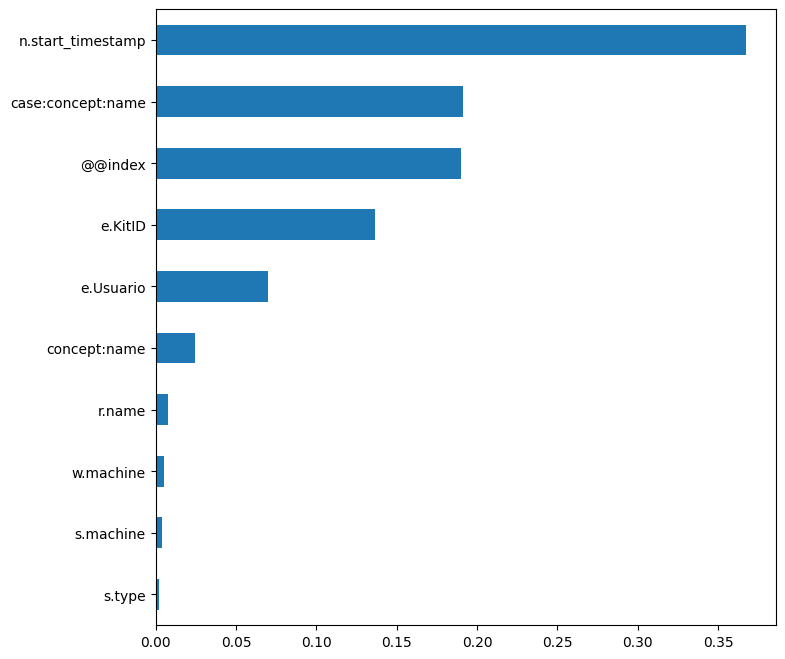

In [507]:
df_new = data.drop('is_delayed', axis=1)

var_imp = pd.DataFrame({'importance': clf.feature_importances_},
                       index=df_new.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False)

In [508]:
print(var_imp.sort_values(by='importance'))

                   importance
s.type               0.002297
s.machine            0.004035
w.machine            0.005498
r.name               0.007655
concept:name         0.024702
e.Usuario            0.070219
e.KitID              0.136485
@@index              0.190224
case:concept:name    0.191545
n.start_timestamp    0.367341
